# PyTorch mutual information neural estimation compression tests

Tests with synthetic high-dimensional data with low intrinsic dimension.

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import mutinfo
import torchmine

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 2


In [5]:
from tqdm import tqdm

In [6]:
from mutinfo.utils.dependent_norm import multivariate_normal_from_MI
from mutinfo.utils.synthetic import normal_to_uniform

In [7]:
from misc.modules import *
from misc.plots import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-l83yev3n because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [8]:
mutual_information = 0.1

n_samples = 5000

In [9]:
min_delta = 2
X_size = 32
Y_size = 32

In [10]:
from mutinfo.utils.synthetic import normal_to_rectangle_coords, rectangle_coords_to_rectangles, params_to_2d_distribution

In [11]:
test_type = "rectangles"

if test_type == "rectangles":
    X_latent_dimension = 4
    Y_latent_dimension = 4
    
    random_variable = multivariate_normal_from_MI(X_latent_dimension, Y_latent_dimension, mutual_information)
    latent_X_Y = normal_to_uniform(random_variable.rvs(n_samples))

    latent_X = normal_to_rectangle_coords(latent_X_Y[:, 0:X_latent_dimension], min_delta, X_size, min_delta, X_size)
    latent_Y = normal_to_rectangle_coords(latent_X_Y[:, X_latent_dimension:X_latent_dimension + Y_latent_dimension], min_delta, Y_size, min_delta, Y_size)
    latent_Z = latent_X[np.random.permutation(latent_X.shape[0])]

    X = rectangle_coords_to_rectangles(latent_X, X_size, X_size)[:,None,:]
    Y = rectangle_coords_to_rectangles(latent_Y, Y_size, Y_size)[:,None,:]
    Z = rectangle_coords_to_rectangles(latent_Z, X_size, X_size)[:,None,:]
    
elif test_type == "gaussians":
    X_latent_dimension = 2
    Y_latent_dimension = 2
    
    random_variable = multivariate_normal_from_MI(X_latent_dimension, Y_latent_dimension, mutual_information)
    latent_X_Y = normal_to_uniform(random_variable.rvs(n_samples))

    latent_X = normal_to_uniform(latent_X_Y[:, 0:X_latent_dimension])
    latent_Y = normal_to_uniform(latent_X_Y[:, X_latent_dimension:X_latent_dimension + Y_latent_dimension])
    latent_Z = latent_X[np.random.permutation(latent_X.shape[0])]
    
    distribution = lambda x, y, params : np.exp(-10.0 * ((x - params[:,0,None,None])**2 + (y - params[:,1,None,None])**2))
    
    X = params_to_2d_distribution(latent_X, distribution, X_size, X_size)[:,None,:]
    Y = params_to_2d_distribution(latent_Y, distribution, Y_size, Y_size)[:,None,:]
    Z = params_to_2d_distribution(latent_Z, distribution, X_size, X_size)[:,None,:]

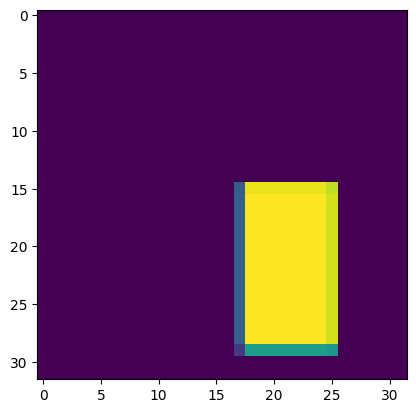

In [12]:
plt.imshow(X[0][0])

In [13]:
batch_size = 512 #n_samples
latent_dataset = torch.utils.data.TensorDataset(torch.tensor(latent_X, dtype=torch.float32), torch.tensor(latent_Y, dtype=torch.float32), torch.tensor(latent_Z, dtype=torch.float32))
latent_dataloader = torch.utils.data.DataLoader(latent_dataset, batch_size=batch_size, shuffle=True)

In [14]:
dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(Z, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
latent_model = BasicDenseT(X_latent_dimension, Y_latent_dimension, inner_dim=400).to(device)
model = BasicConv2dT(X_size, Y_size).to(device)

In [16]:
# Training parameters.
latent_loss = torchmine.loss.DVRLoss(biased=False, alpha=1e-2)
latent_opt = torch.optim.Adam(latent_model.parameters(), lr=1e-3)

loss = torchmine.loss.DVRLoss(biased=False, alpha=1e-2)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
import matplotlib
from matplotlib import pyplot as plt

In [18]:
from IPython.display import clear_output
n_epochs = 5000

estimated_latent_MI = []
estimated_MI = []
for epoch in range(1, n_epochs + 1):    
    # Training.
    print(f"Epoch №{epoch}")
    
    for index, batch in tqdm(enumerate(latent_dataloader)):
        x, y, z = batch
        
        latent_model.zero_grad()
        T_joined   = latent_model(x.to(device), y.to(device))
        T_marginal = latent_model(x.to(device), y.to(device), permute=True)
        _loss = latent_loss(T_joined, T_marginal)
        _loss.backward()
        latent_opt.step()
        
    estimated_latent_MI.append(latent_model.get_mutual_information(latent_dataloader, latent_loss, device))
    
    for index, batch in tqdm(enumerate(dataloader)):
        x, y, z = batch
        
        model.zero_grad()
        T_joined   = model(x.to(device), y.to(device))
        T_marginal = model(x.to(device), y.to(device), permute=True)
        _loss = loss(T_joined, T_marginal)
        _loss.backward()
        opt.step()
        
    estimated_MI.append(model.get_mutual_information(dataloader, loss, device))
    
    clear_output(wait=True)
    
    #plot_estimated_MI_trainig(mutual_information, np.arange(1, epoch+1), estimated_MI, estimated_latent_MI)

    print(f"Current estimate: {estimated_MI[-1]:.3f}")
    print(f"Current exp(T) moving average: {loss.moving_average:.4f}")

Current estimate: 0.998
Current exp(T) moving average: 554.9224


In [19]:
window_size = 500
subrange = np.maximum(estimated_MI[-window_size:], 0.0)
final_estimate = np.mean(subrange)
final_estimate_std = np.std(subrange) / np.sqrt(len(subrange))

In [20]:
print(f"Final estimate: {final_estimate} ± {final_estimate_std}")

Final estimate: 1.1770340209457397 ± 0.01538171142375998


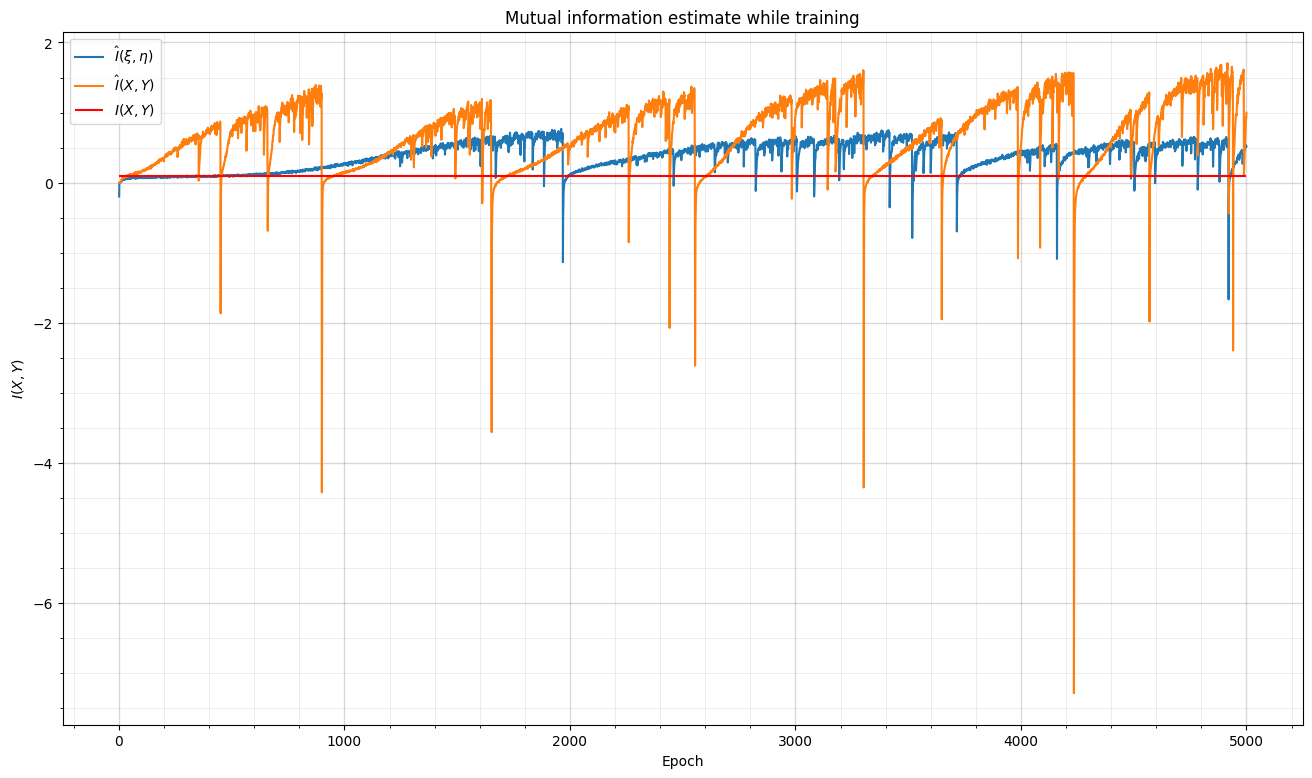

In [21]:
plot_estimated_MI_trainig(mutual_information, np.arange(1, epoch+1), estimated_MI, estimated_latent_MI)

### Saving the results

In [22]:
path = f"../../data/mutual_information/synthetic/{test_type}_{X_size}x{X_size}/"

In [23]:
import pandas as pd

In [24]:
data = pd.DataFrame()

In [25]:
data["epoch"] = np.arange(1, n_epochs+1)
data["estimated_MI"] = estimated_MI
data["estimated_latent_MI"] = estimated_latent_MI

In [26]:
data.to_csv(path + f"{mutual_information:.1f}.csv", index=False)

In [27]:
final = pd.DataFrame()
final["final_estimate"] = [final_estimate]
final["final_estimate_std"] = [final_estimate_std]

final.to_csv(path + f"final_{mutual_information:.1f}.csv", index=False)